BiLSTMVertical:
This is a module that implements a Bidirectional Long Short-Term Memory (BiLSTM) layer with a vertical direction of computation.
It takes two arguments: input_size and hidden_size, which determine the input and hidden state dimensions of the LSTM.
Inside the __init__ method, it initializes an nn.LSTM module with the specified input and hidden sizes. It's set to be bidirectional (bidirectional=True) and accepts input data in batches (batch_first=True).
In the forward method, it applies the BiLSTM to the input tensor x and returns the output.
BiLSTMHorizontal:
This is another module similar to BiLSTMVertical, but it implements a BiLSTM layer with a horizontal direction of computation.
It has the same constructor and forward method structure as BiLSTMVertical.
FullyConnectedLayer:
This module represents a fully connected (linear) layer in a neural network.
It takes two arguments: input_size and output_size, determining the input and output dimensions of the linear layer.
In the __init__ method, it initializes an nn.Linear module with the specified input and output sizes.
In the forward method, it applies the linear transformation to the input tensor x and returns the output.

In [1]:
import torch
import torch.nn as nn

class BiLSTMVertical(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BiLSTMVertical, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True)
        
    def forward(self, x):
        output, _ = self.lstm(x)
        return output

class BiLSTMHorizontal(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BiLSTMHorizontal, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True)
        
    def forward(self, x):
        output, _ = self.lstm(x)
        return output

class FullyConnectedLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(FullyConnectedLayer, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        output = self.fc(x)
        return output



Sequencer2D
Is a sequencer in which the input data (images) are splitted into vertical adn horiziontal component, then vertical data will be passed as input to BilstmVertical ,while horizontal_data will be passed to BiLSTMHorizontal, to do so the input data are first processed in such a way we'll have a tensor with vertical data of each image and another tensor with horizontal data of each image. Oncee we get the outputs from both BiLSTMvertical and BiLSTMHorizontal, we 'll concatenate them and pass as input the result to Fully Connected Layer . At the end of the sequencer the results will be a list of tensor ( each tensor has inside data belongs to each image processed above)

In [48]:


class Sequencer2D(nn.Module):
    def __init__(self, input_size, hidden_size, mlp_input_size, mlp_output_size):
        super(Sequencer2D, self).__init__()

       
        vertical_bilstm = BiLSTMVertical(input_size, hidden_size)
        horizontal_bilstm = BiLSTMHorizontal(input_size, hidden_size)
        fully_connected = FullyConnectedLayer( mlp_input_size,mlp_output_size)  

        # Move models to GPU if available
        #vertical_bilstm.to(device)
        #horizontal_bilstm.to(device)
        #fully_connected.to(device)

        self.vertical_bilstm = vertical_bilstm
        self.horizontal_bilstm = horizontal_bilstm
        self.fully_connected = fully_connected

    def forward(self, x):
        if isinstance(x, list):
            x = torch.stack(x)
        if len(x.shape)==4:
            batch_size,channel, height, width = x.size()
            x=x.squeeze(1)
        elif len(x.shape) == 3 :
            batch_size, height, width = x.size()
        output=[]
        for index in range(batch_size):
            x_vertical = x[index][:, :height//2]  #split the image vertically
            x_horizontal = x[index][ :,width//2:]   #split image horizontally

            vertical_data = x_vertical.permute( 1,0) #permutation to fit bilstm
            horizontal_data = x_horizontal.permute( 1,0)#same here
            
            
            
            H_ver = self.vertical_bilstm(vertical_data)
            H_hor = self.horizontal_bilstm(horizontal_data)
            
            
            H_ver = torch.tensor(H_ver, dtype=torch.float32).permute(1,0) #permute to fit torch.cat
            H_hor = torch.tensor(H_hor, dtype=torch.float32).permute(1,0)
            
           
            
            
            H_concat = torch.cat((H_ver, H_hor), dim=1)#concatenaiton of the horizontal and vertical bilstm outputs
            H_concat = H_concat.unsqueeze(0) #set dimension to fit fully conncted layer

            
            
            
            
            
            
            output_pieces = self.fully_connected(H_concat)
            
            output_pieces=torch.tensor(output_pieces, dtype=torch.float32)
            output.append(output_pieces) #add output to lists of each image data processed here
        
        return output


Patch Embedding : this costum function given an image , a patch size, will splitted the image in image_size/patch_size pieces.

image_size: The size of the input image. It represents both the height and width of the image.
patch_size: The size of each non-overlapping patch that the image is divided into.
in_channels: The number of input channels in the image. For RGB images, this is typically 3 (for the red, green, and blue channels).
embed_dim: The dimension of the embedded representations for each patch.


In [25]:


class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.embed_dim = embed_dim

        
        self.num_patches = (image_size // patch_size) ** 2 #compute the number of patches in such a way they won't overlap

        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size) #convolutional layer takes the input image, divides it into patches, and embeds each patch into a lower-dimensional representation.

   
    def forward(self, x):
        x = self.projection(x)
        B, C, H, W = x.size()
        x = x.reshape(B, self.num_patches, C, -1).permute(0, 2, 1, 3)
        x = x.flatten(2).transpose(1, 2)
        return x

    def output_dimension(self):
        return self.embed_dim * self.num_patches


PW Linear Layer compute  pointwise linear transformations on a list of input tensors.

In [4]:
class PWLinearLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(PWLinearLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, input_list):
        output_list = []
        for input_tensor in input_list:
            output_tensor = self.linear(input_tensor)
            output_list.append(output_tensor)
        stacked_output = torch.stack(output_list, dim=0)
        return stacked_output


Patch merging, take the images splitted in patches (for examples by patch embedding ) and merge it together, the number of patches merged is based on the output channlee and  the  scale factor number.

In [5]:
class PatchMerging(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor):
        super(PatchMerging, self).__init__()
        self.scale_factor = scale_factor
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, patch_list):
        
        x = torch.cat(patch_list, dim=1).permute(1,2,0) # compination of the list of patches into a single tensor + peermutation to fit convolutional layer
        
        
        x = self.conv(x) # Apply to the input x, a 1x1 convolution to merge the patches together
        
        
        x = nn.functional.interpolate(x, scale_factor=self.scale_factor, mode='nearest') #resize the feature map using a nearest-neighbor upsampling

        return x


Global avarage pooling 

In [6]:
class GlobalAveragePooling(nn.Module):
    def __init__(self):
        super(GlobalAveragePooling, self).__init__()

    def forward(self, x):
        
        x = torch.mean(x, dim=(-2, -1))# perform global average pooling along spatial dimensions using the mean
        return x


Sequencer2Dmodel-> Is an architecture that resambles vision transformer except for the fact that Sequencer2D model is using BiLSTM2D (splitting image in horizzontal and vertical data) instead of self attention. It started with patch embedding layeer so the images will be divided in 8x8 patches, than ,after a normalization, there is the first sequence block of 4 Sequencer , the output of this block converge in PatchMerging, where the patches are resembled together ,then there is a second sequencer block made of 3 sequencer2d, followed by pointwise linear layer,then other sequencer block with 8 sequencers2D, then other point wise linear layer and  the final sequencerBlock with 3 sequencer2D layer and at the end there are linears+ global avarage pooling layers in order to make the output dimension as expected-

The parameters are the one suggested by the paper

In [49]:

class Sequencer2DModel(nn.Module):
    def __init__(self, num_classes, in_channels):
        super(Sequencer2DModel, self).__init__()

        self.num_classes = num_classes
        

       
        self.patch_embedding_1 = PatchEmbedding(32, 8, in_channels, 16)#  patch embedding with an 8x8 kernel size for each patch
        self.ln_1 = nn.LayerNorm(16)

       
        self.sequencer_block_1 =  nn.Sequential(
            Sequencer2D(16, 48, 6, 96),
            Sequencer2D(96, 96, 96, 192),
            Sequencer2D(192, 192, 192,384),
            Sequencer2D(384, 192, 384,384)
        )


       
        self.patch_merging=PatchMerging(24576,64,2)#it still depend on batch size!!! it is sooo wrong

      
        self.sequencer_block_2 =  nn.Sequential(
            Sequencer2D(384, 192, 3,384),
            Sequencer2D(384, 192, 384,384),
            Sequencer2D(384, 192, 384,384)
        )

       
        self.pw_linear_1 = PWLinearLayer( 384,384)
        
        
        self.sequencer_block_3 =  nn.Sequential(
            Sequencer2D(384, 192, 384,384),
            Sequencer2D(384, 192, 384,384),
            Sequencer2D(384, 192, 384,384),
            Sequencer2D(384, 192, 384,384),
            Sequencer2D(384, 192, 384,384),
            Sequencer2D(384, 192, 384,384),
            Sequencer2D(384, 192, 384,384),
            Sequencer2D(384, 192, 384,384),
            
            
           
        )

        self.pw_linear_2 = PWLinearLayer(384, 384)

        
        self.sequencer_block_4 =  nn.Sequential(
            Sequencer2D(384, 192, 384,384),
            Sequencer2D(384, 192, 384,384),
            Sequencer2D(384, 192, 384,384)
        )
        self.pw_linear_3 = PWLinearLayer(384, 384)


        
        self.ln_2 = nn.LayerNorm(384)

        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 384))

        
        self.fc = nn.Linear(384, num_classes)
        
        
        

    def forward(self, x):
       
        
        x = x.to(torch.float32).permute(0,3,1,2)  
        x = self.patch_embedding_1(x)
        x = self.ln_1(x)

        
        x = self.sequencer_block_1(x)
        
        print(len(x))
        
        x = self.patch_merging(x)
        
        
        x = self.sequencer_block_2(x)

        
        x = self.pw_linear_1(x)
        
        x = self.sequencer_block_3(x)
        
        
        x = self.pw_linear_2(x)

    
        x = self.sequencer_block_4(x)
        
        x = self.pw_linear_3(x)

        
        x = self.ln_2(x)
        
        x = self.global_avg_pool(x)
        
        x = self.fc(x)


        

        return x



CustomCifar2, this custom function process imace into the dataset in order to take only the first five classes, I've tried this apporch because each batch processing was too slowly.

In [9]:
from torchvision import datasets
import numpy as np
from torch.utils.data import Dataset

class CustomCIFAR2(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(CustomCIFAR2, self).__init__()
        self.cifar10 = datasets.CIFAR10(root, train=train, transform=transform, target_transform=target_transform, download=download)
        
        
        self.keep_classes = [0, 1,2,3,4] 

        
        self.data, self.targets = self.filter_classes()

    def filter_classes(self):
        mask = np.isin(self.cifar10.targets, self.keep_classes)
        data = [self.cifar10.data[i] for i, include in enumerate(mask) if include]
        targets = [self.cifar10.targets[i] for i, include in enumerate(mask) if include]
        return data, targets

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        return img, target

    def __len__(self):
        return len(self.data)


Load the model, with trnsform.Compose function that helps me with preprocessing and data augmentation:

In [46]:
import torch.optim as optim

import torchvision.transforms as transforms
from torch.utils.data import DataLoader

model = Sequencer2DModel(num_classes=5, in_channels=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


batch_size = 64

num_epochs = 10

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),   # Randomly flip the image horizontally
    transforms.RandomRotation(15),      # Randomly rotate the image by up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.8),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),# Adjust brightness, contrast, saturation, and hue
    transforms.RandomResizedCrop(16),
    transforms.RandomResizedCrop(4),# Randomly crop and resize the image to 224x224
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomAffine(degrees=4, translate=(0.4, 0.1)),# Randomly translate the image
    transforms.ToTensor(),              # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image

])


#train_dataset = torchvision.datasets.CIFAR10(root='./cifar-10-batches-py', train=True, transform=transform) #use this for complete dataset
custom_dataset = CustomCIFAR2(root='root='./cifar-10-batches-py', train=True, transform=transform, download=True)
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)


Files already downloaded and verified


In this part the code aims to train the model: it iterates over  the number of epochs and then over all the batchs in the datasets takes the images and the labels and pass it to the model ,get the model outputs, and reshape it in order to make it fit well the loss function(CrossEntropyLoss function , 'cause it is a multiclassification problem), then performs backward step, and calls the optimizer (Adam starting with 0.01 learning rate) ,then it takes the prediction and compere it with the true labels,after that the accuracy is computed simply by divided the true presiction to the total  number of images processed.

In [47]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
all_labels=[]
all_accuracy=[]
all_loss=[]
# Training phase
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    running_loss = 0.0  # track the loss for 200 batch
    
    for i, data in enumerate(data_loader, 0):
        labels_=[]
        if i==390: #jump one batchs due to  incompatibility 
            continue
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
    
       
        optimizer.zero_grad() #reset the gradient
        
        
        outputs = model(inputs)
        print(outputs.shape)
        
        outputs=outputs[:,0]
        outputs=outputs[:,0]
        
        
        loss = criterion(outputs, labels)
        all_loss.append(loss)
      
        loss.backward()
        optimizer.step()

        
        running_loss += loss.item()
        
       
        predicted_probabilities = outputs.argmax(dim=1)
        #correct = (predicted_probabilities == labels).sum().item() #sum up all the right prediction
        _,predicted_labels = torch.max(outputs,dim=1)
        correct = (predicted_labels == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)
        
        
        print(labels)
        print(predicted_labels)

        batch_accuracy = (correct / labels.size(0)) *100
        all_accuracy.append(batch_accuracy)
        for label in labels:
            all_labels.append(labels)
        print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(data_loader)}] Loss: {loss.item():.4f} Accuracy: {batch_accuracy:.2f}%")
        if i % 200 == 199:  
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(data_loader)}] Loss: {loss.item():.4f} Accuracy: {batch_accuracy:.2f}%")
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}")
            running_loss = 0.0

    epoch_accuracy = (total_correct / total_samples) * 100.0
    print(f"Epoch [{epoch+1}/{num_epochs}] Accuracy: {epoch_accuracy:.2f}%")

print("Finished Training")


torch.Size([64, 16, 4])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x3072 and 96x6)

<ipython-input-40-6bac0eae6cdf>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_loss=torch.tensor(all_loss)


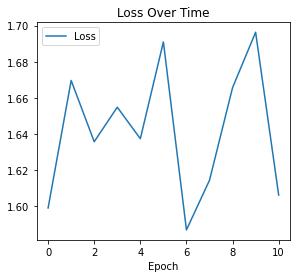

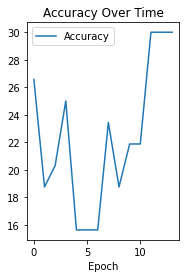

In [40]:

import matplotlib.pyplot as plt
all_loss=torch.tensor(all_loss)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(all_loss.detach().numpy(), label='Loss')
plt.xlabel('Epoch')
plt.title('Loss Over Time')
plt.legend()
plt.show()
plt.subplot(1, 2, 2)
plt.plot(all_accuracy, label='Accuracy')
plt.xlabel('Epoch')
plt.title('Accuracy Over Time')
plt.legend()

plt.show()

Code for evaluation of the model over the dataset, here it is charged the test dataset as It was doing eiht the train dataset. Then the data are iterating and processed into the model to see if the prediciton match the actual labels, the code is way similar to the one used in the training phase except for the part of optimizer/backward .

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(15),     
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    
    transforms.RandomResizedCrop(16),
    transforms.RandomResizedCrop(4),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomAffine(degrees=4, translate=(0.4, 0.1)),
    transforms.ToTensor(),     
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  

])



test_dataset = CustomCIFAR2(
    root='./cifar-10-batches-py', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


model = Sequencer2DModel(num_classes=5, in_channels=3)




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


model.eval()

all_predictions = []
all_labels = []
all_accuracy=[]
c=0

total_correct=0
total_samples=0
with torch.no_grad():
    for inputs, labels in test_loader:
        
        c+=1
        print(c)
        if c==78:
            continue
        inputs, labels = inputs.to(device), labels.to(device)
       
        
        outputs = model(inputs)

        
        
        predicted_labels = (torch.sigmoid(outputs) > 0.5).float()
        predicted_labels = predicted_labels.argmax(dim=1)
        predicted_labels= predicted_labels.argmax(dim=1)
        
        
        
        correct = (predicted_labels[:,0] == labels).sum().item()
        
        total_correct += correct
        total_samples += len(labels)
        
        accuracy = (total_correct / total_samples) * 100.0  
        
        
        all_accuracy.append(accuracy)
        for label in labels:
            all_labels.append(labels)
        
        
        print(f"batch: [{c}/{len(data_loader)}]",f"Test Accuracy: {accuracy :.2f}%")

accuracy = accuracy_score(all_labels, all_predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


code used to save the model

In [ ]:
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import pickle

model_pkl_file = "./sequencer_model384S.pkl"

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)